# Benchmarking the increment in finite differences

We will apply HF, CCSD, and FCI to obtaining the PESs and the forces for $H_2$. Even in the case of FCI, the finite difference method is sensitive to numerical noise. If we take a very tiny step in the coordinates, the energy difference will be very small and the difference will not be trustworthy. If we on the other hand take too large steps, the difference will be a very bad approximation for the derivative in which we take the limit to zero increment. It is always a hard task to decide which increment to take and it will depend on the system.

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import tequila as tq
import pickle
import matplotlib.pyplot as plt
from utility import get_molecular_data, obtain_PES
from force_utility import finite_difference_PES, noisy_finite_difference_PES, vqe_PES, finite_difference_vqe_PES

iampatient = False

basis = 'sto-3g'
qubit_transform = 'jw'

In [2]:
bond_lengths = np.linspace(0.2,2.6,15)
deltas = np.array([1e-7, 1e-5, 1e-3, 1e-1])
methods = ['fci', 'hf', 'ccsd']
styles = {'fci': {'color': 'blue', 'linestyle': 'solid'}, \
          'hf': {'color': 'orange', 'marker': 'o', 'linestyle': ''}, \
          'ccsd': {'color': 'purple', 'marker': 'o', 'linestyle': ''}, \
          'vqe': {'color': 'green', 'marker': 'o', 'linestyle': ''}}
symbols = ['x', '+', 'o', 's', 'D', '*']

For the $H_2$ molecule, there is only a single variable: the bond length. If the molecule is along the x-axis, the force on the right $H$ atom will be $\frac{E(x+\delta x) - E(x-\delta x)}{2\delta x}$ while the force on the left atom will be the opposite sign. We don't have to calculate both in this case.

In [3]:
%%capture 
# remove previous line if you want to see all the energies roll down your screen
energies = {} 
forces = {}
if iampatient:
    for m in methods:
        energies[m] = obtain_PES('h2', bond_lengths, basis, method=m)
        for d in deltas:
            forces.setdefault(m, []).append({'delta': d, 'force': finite_difference_PES(bond_lengths, d, basis, molecule='h2', method=m)})
else:
    with open("fd_delta.pkl", "rb") as infile:
        loaded = pickle.load(infile)
        energies = loaded['energies']
        forces = loaded['forces']

The next plot shows each method with all the increments. Can you decide which increment is best?

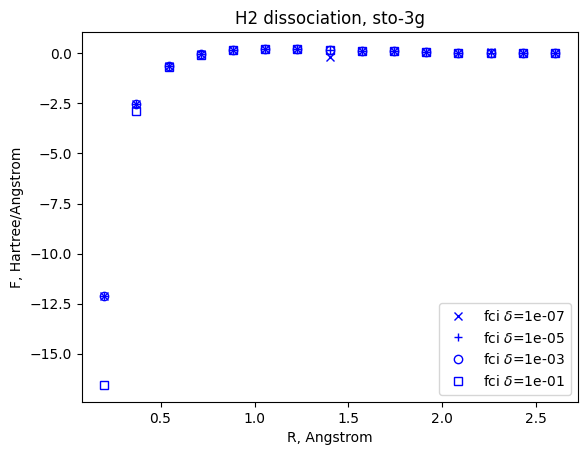

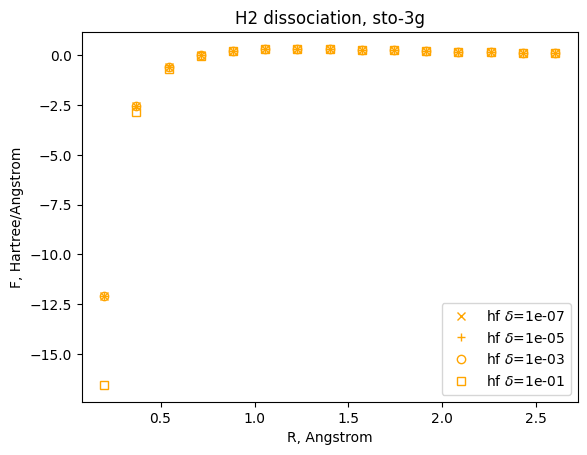

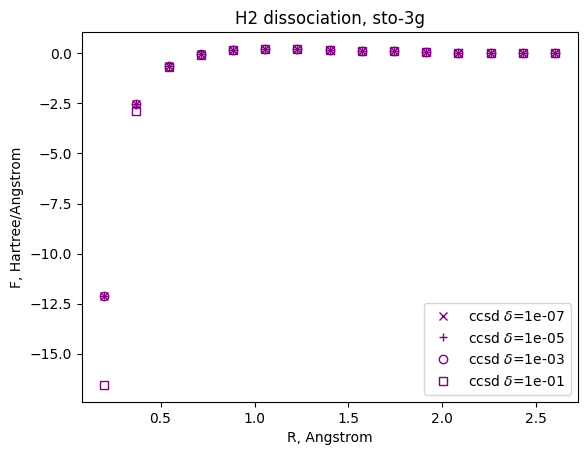

In [4]:
for method, force_array in forces.items():
    plt.title('H2 dissociation, ' + basis)
    plt.xlabel('R, Angstrom')
    plt.ylabel('F, Hartree/Angstrom')
    for idx, force in enumerate(force_array):
        plt.plot(bond_lengths, force['force'], label=method + ' $\delta$={:1.0e}'.format(force['delta']), color=styles[method]['color'], linestyle='', marker=symbols[idx], fillstyle='none')
    plt.legend()
    plt.show()

Pick the increment you like most and compare the different methods. Put the index of the increment in the variable ${\tt idx}$, remember Python uses 0-based indexing and the list of increments was $[1e-7,1e-5,1e-3,1e-1]$.

How do the different methods compare to FCI?

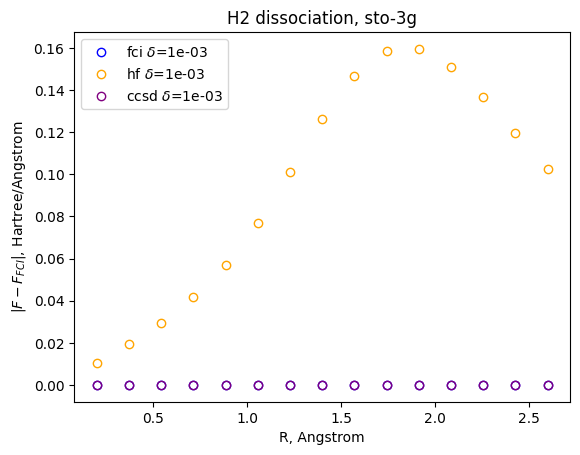

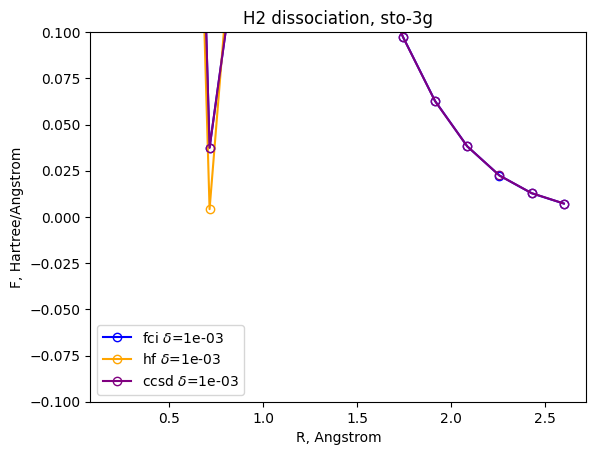

In [5]:
idx=2

plt.title('H2 dissociation, ' + basis)
plt.xlabel('R, Angstrom')
plt.ylabel('$|F-F_{FCI}|$, Hartree/Angstrom')

idx=2
for method, force_array in forces.items():
    plt.plot(bond_lengths, np.abs(force_array[idx]['force']-forces['fci'][idx]['force']), label=method + ' $\delta$={:1.0e}'.format(force_array[idx]['delta']), color=styles[method]['color'], linestyle='', marker=symbols[idx], fillstyle='none')
plt.legend()
plt.show()

#Plot H2 PESs
plt.title('H2 dissociation, ' + basis)
plt.xlabel('R, Angstrom')
plt.ylabel('F, Hartree/Angstrom')

for method, force_array in forces.items():
    plt.plot(bond_lengths, np.abs(force_array[idx]['force']), label=method + ' $\delta$={:1.0e}'.format(force_array[idx]['delta']), color=styles[method]['color'], linestyle='solid', marker=symbols[idx], fillstyle='none')
plt.legend()
plt.ylim(-0.1,0.1)
plt.show()


What does it mean if the force becomes 0? Does the force become 0 at the same bond length for all methods? Can you find the equilibrium distance for $H_2$ online and compare to what you find? Does it agree with what you see on the PES curve below? If you want, you can add more points around the equilibrium bond length and rerun the notebook to better resolve this special point.

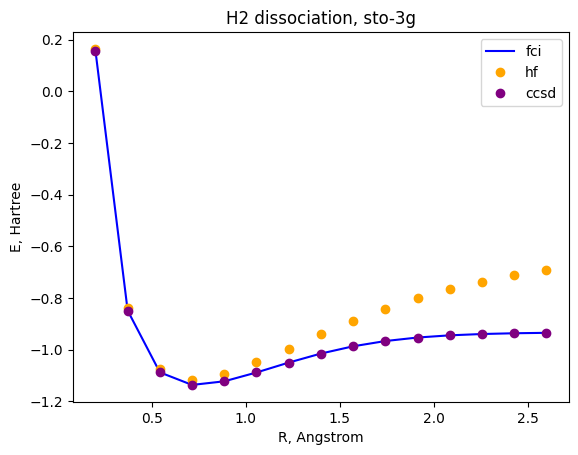

In [6]:
#Plot H2 PESs
plt.title('H2 dissociation, ' + basis)
plt.xlabel('R, Angstrom')
plt.ylabel('E, Hartree')

for method, energy in energies.items():
    plt.plot(bond_lengths, energy, label=method, **styles[method])
plt.legend()

# Benchmarking finite differences in a noisy setting

We will apply HF, CCSD, and FCI to obtaining the PESs and the forces for $H_2$ but we will add some random noise to the energy evaluation. This will affect the accuracy of the finite difference derivative.

In [7]:
amplitudes = np.array([1e-7, 1e-5, 1e-3, 1e-1])

In [8]:
%%capture 
# remove previous line if you want to see all the energies roll down your screen
noisy_energies = {} 
noisy_forces = {}
d = deltas[2] # we fix the increment to 1e-3
if iampatient:
    for m in methods:
        for amp in amplitudes:
            noisy_energies.setdefault(m, []).append({'amplitude': amp, 'energy': obtain_PES('h2', bond_lengths, basis, method=m) + amp * (1.-2.*np.random.rand(*bond_lengths.shape))})
            noisy_forces.setdefault(m, []).append({'amplitude': amp, 'force': noisy_finite_difference_PES(bond_lengths, d, amp, basis, molecule='h2', method=m)})
else:
    with open("fd_amplitude.pkl", "rb") as infile:
        loaded = pickle.load(infile)
        noisy_energies = loaded['energies']
        noisy_forces = loaded['forces']

You can see the effect on the energies below

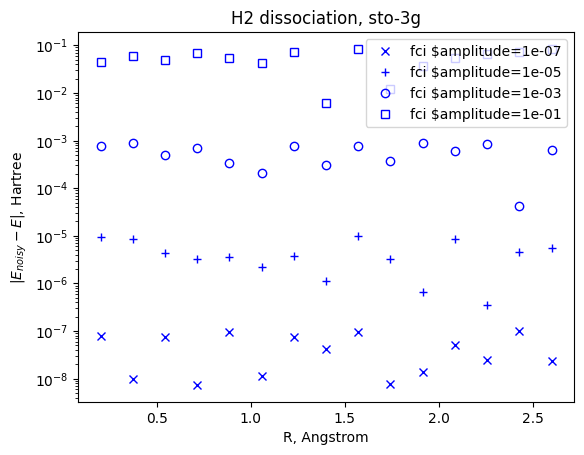

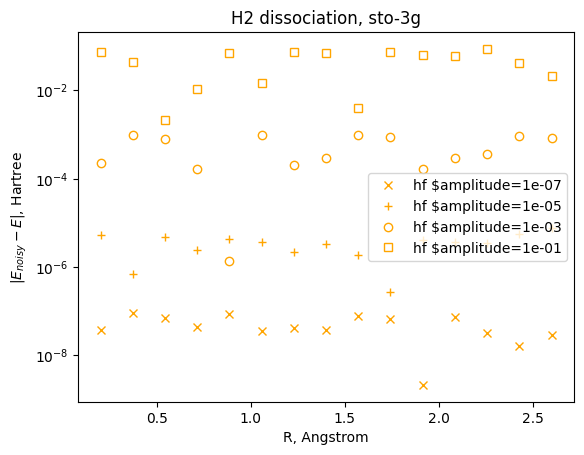

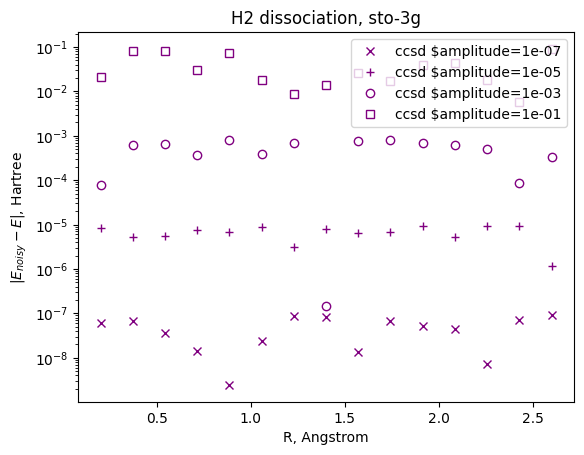

In [9]:
for method, noisy_energy_array in noisy_energies.items():
    plt.title('H2 dissociation, ' + basis)
    plt.xlabel('R, Angstrom')
    plt.ylabel('$|E_{noisy}-E|$, Hartree')
    plt.yscale('log')
    for idx, noisy_energy in enumerate(noisy_energy_array):
        plot_data =  np.abs(energies[method] - noisy_energy['energy'])
        plt.plot(bond_lengths, plot_data, label=method + ' $amplitude={:1.0e}'.format(noisy_energy['amplitude']), color=styles[method]['color'], linestyle='', marker=symbols[idx], fillstyle='none')
    plt.legend()
    plt.show()

What is an acceptable noise level on the energy? What is the corresponding maximum absolute error on the force? How does this compare to the absolute values of the force? Calculate the mean/max/std of the errors.

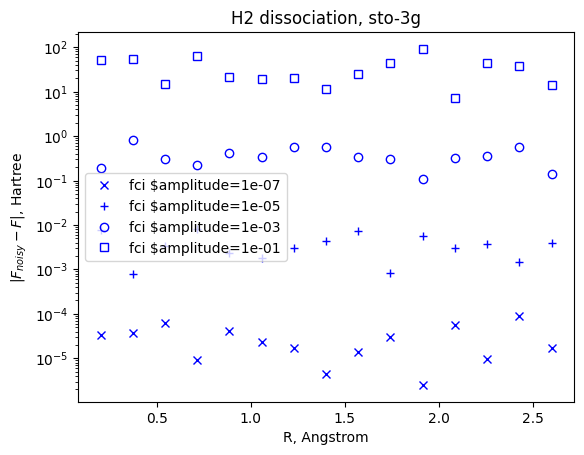

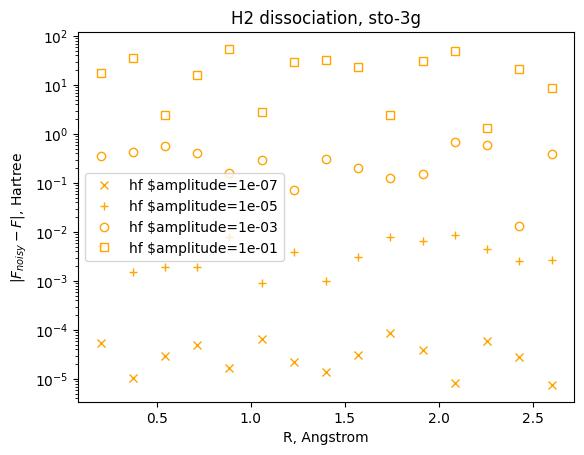

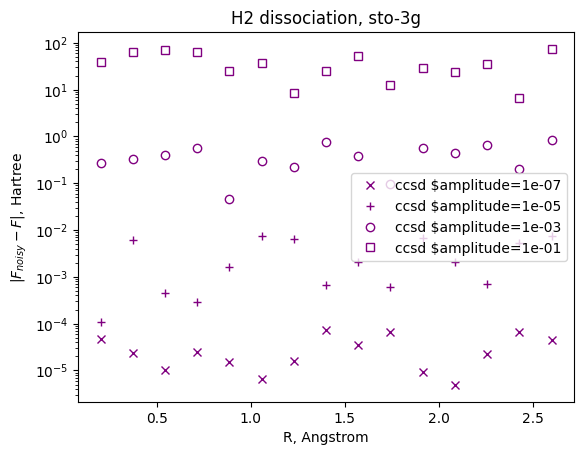

In [10]:
for method, noisy_force_array in noisy_forces.items():
    plt.title('H2 dissociation, ' + basis)
    plt.xlabel('R, Angstrom')
    plt.ylabel('$|F_{noisy}-F|$, Hartree')
    plt.yscale('log')
    for idx, noisy_force in enumerate(noisy_force_array):
        plot_data = np.abs(forces[method][2]['force'] - noisy_force['force'])
        plt.plot(bond_lengths, plot_data, label=method + ' $amplitude={:1.0e}'.format(noisy_force['amplitude']), color=styles[method]['color'], linestyle='', marker=symbols[idx], fillstyle='none')
    plt.legend()
    plt.show()


What would be the equilibrium bond distance if we took $1mHa$ as an acceptable energy error?

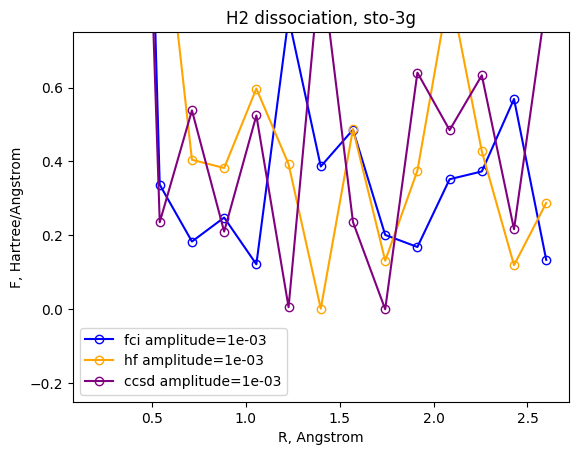

In [11]:
#Plot H2 PESs
idx=2
plt.title('H2 dissociation, ' + basis)
plt.xlabel('R, Angstrom')
plt.ylabel('F, Hartree/Angstrom')

for method, noisy_force_array in noisy_forces.items():
    plt.plot(bond_lengths, np.abs(noisy_force_array[idx]['force']), label=method + ' amplitude={:1.0e}'.format(noisy_force_array[idx]['amplitude']), color=styles[method]['color'], linestyle='solid', marker=symbols[idx], fillstyle='none')
plt.legend()
plt.ylim(-0.25,0.75)
plt.show()

# Benchmarking finite differences with VQE

We will now apply the finite difference method to a VQE example. On NISQ quantum computers there are several sources of error like the finite number of measurements, the decoherence of the machine, measurement errors. Each of these will play a role and decrease the accuracy of a finite difference method.

Noisy simulations and sampled simulations are much slower than perfect statevector simulations. We will limit this exploration to the tapered Hamiltonian for $H_2$ which has only a single qubit. Which unitary should perfectly diagonalize this Hamiltonian? Which gate should we add to the circuit to get this unitary?

We start by adding shot noise by limiting the number of shots per measurement.

In [12]:
# remove previous line if you want to see all the energies roll down your screen
vqe_energies = {} 
vqe_forces = {}
d = deltas[2] # we fix the increment to 1e-3
samples = [None, 100, 1000] # if you are brave or have a good computer you can go higher with the number of samples
if iampatient:
    for m in ['vqe']:
        for s in samples:
            vqe_energies.setdefault(m, []).append({'samples': s, 'energy': vqe_PES('h2', bond_lengths, basis, samples=s)})
            vqe_forces.setdefault(m, []).append({'samples': s, 'force': finite_difference_vqe_PES(bond_lengths, d, basis, molecule='h2', samples=s)})
else:
    with open("fd_samples.pkl", "rb") as infile:
        loaded = pickle.load(infile)
        vqe_energies = loaded['energies']
        vqe_forces = loaded['forces']

How high should the number of measurements be to get to chemical accuracy? What is the accuracy you expect for the infinite number of measurements?

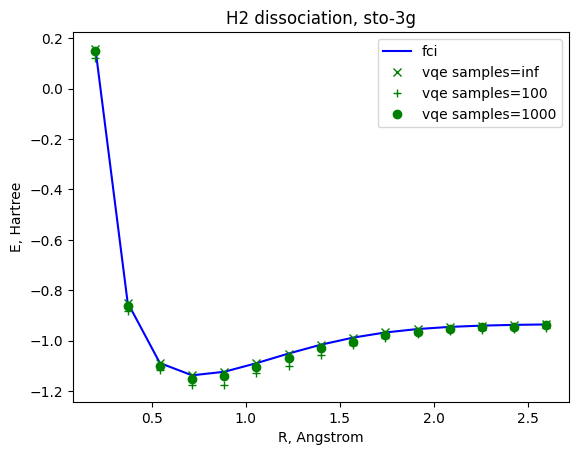

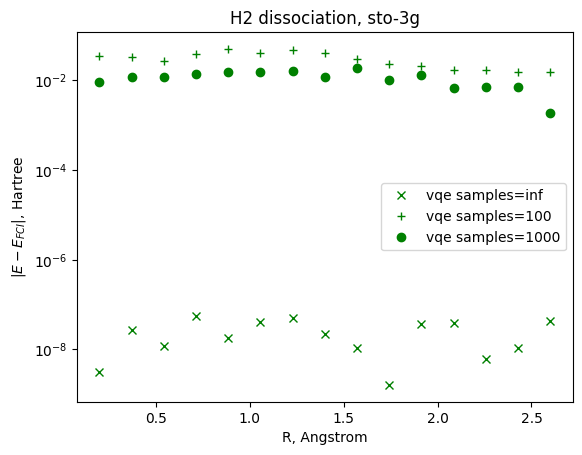

In [13]:
#Plot H2 PESs
plt.title('H2 dissociation, ' + basis)
plt.xlabel('R, Angstrom')
plt.ylabel('E, Hartree')


plt.plot(bond_lengths, energies['fci'], label='fci', **styles['fci'])
for idx, energy in enumerate(vqe_energies['vqe']):
    plt.plot(bond_lengths, energy['energy'], label='vqe samples=' + str(energy['samples'] or np.inf), color=styles['vqe']['color'], linestyle='', marker=symbols[idx])
plt.legend()
plt.show()

plt.title('H2 dissociation, ' + basis)
plt.xlabel('R, Angstrom')
plt.ylabel('$|E-E_{FCI}|$, Hartree')

for idx, energy in enumerate(vqe_energies['vqe']):
    plt.plot(bond_lengths, np.abs(energy['energy']-energies['fci']), label='vqe samples=' + str(energy['samples'] or np.inf), color=styles['vqe']['color'], linestyle='', marker=symbols[idx])
plt.legend()
plt.yscale('log')
plt.show()

How far does this number of shots get you for the force accuracy?

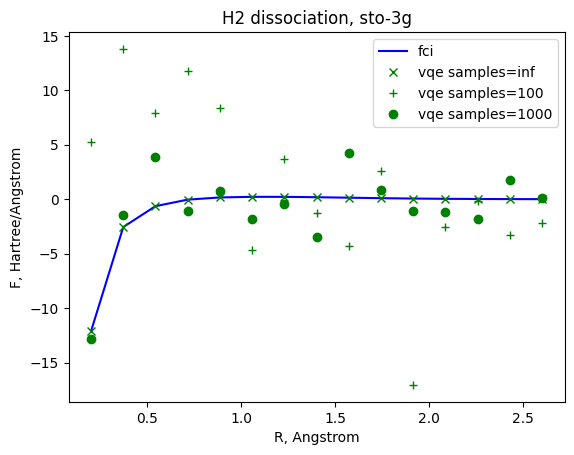

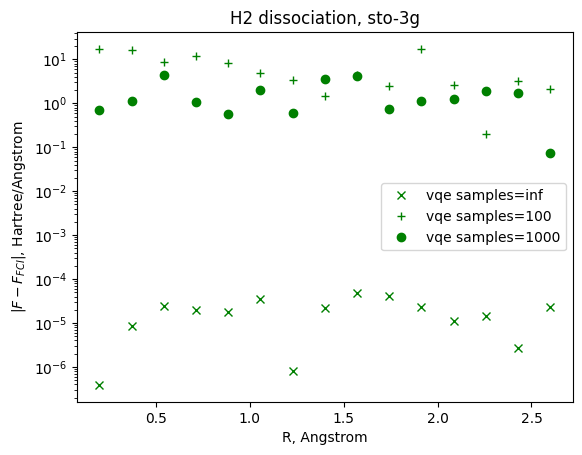

In [14]:
plt.title('H2 dissociation, ' + basis)
plt.xlabel('R, Angstrom')
plt.ylabel('F, Hartree/Angstrom')


plt.plot(bond_lengths, forces['fci'][2]['force'], label='fci', **styles['fci'])
for idx, force in enumerate(vqe_forces['vqe']):
    plt.plot(bond_lengths, force['force'], label='vqe samples=' + str(force['samples'] or np.inf), color=styles['vqe']['color'], linestyle='', marker=symbols[idx])
plt.legend()
plt.show()

plt.title('H2 dissociation, ' + basis)
plt.xlabel('R, Angstrom')
plt.ylabel('$|F-F_{FCI}|$, Hartree/Angstrom')

for idx, force in enumerate(vqe_forces['vqe']):
    plt.plot(bond_lengths, np.abs(force['force'] - forces['fci'][2]['force']), label='vqe samples=' + str(force['samples'] or np.inf), color=styles['vqe']['color'], linestyle='', marker=symbols[idx])
plt.legend()
plt.yscale('log')
plt.show()

We will now explore different noise models. You can read [this notebook](https://nbviewer.org/github/tequilahub/tequila-tutorials/blob/main/NoisySimulation.ipynb) on noisy simulation with tequila. We'll pick amplitude damping and bit flip and their combination but you can change that if you like. 

In [15]:
from tequila.circuit.noise import BitFlip,PhaseFlip,AmplitudeDamp,PhaseDamp,PhaseAmplitudeDamp,DepolarizingError
damp=AmplitudeDamp(0.1,1)
flip=BitFlip(0.1,1)

noises={'flip':flip, 'damp': damp,'flip + damp': damp + flip}
noisy_vqe_energies = {} 
noisy_vqe_forces = {}
d = deltas[2] # we fix the increment to 1e-3
s = None # if you are brave or have a good computer you can go higher with the number of samples
if iampatient:
    for m in ['vqe']:
        for n_name, n in noises.items():
            noisy_vqe_energies.setdefault(m, []).append({'noise': n_name, 'energy': vqe_PES('h2', bond_lengths, basis, samples=s, noise=n)})
            noisy_vqe_forces.setdefault(m, []).append({'noise': n_name, 'force': finite_difference_vqe_PES(bond_lengths, d, basis, molecule='h2', samples=s, noise=n)})
else:
    with open("fd_noise.pkl", "rb") as infile:
        loaded = pickle.load(infile)
        noisy_vqe_energies = loaded['energies']
        noisy_vqe_forces = loaded['forces']

Which noise source is more detrimental to the energy? Why is it that the bit flip channel does not influence the energy that much? How could you increase that effect?

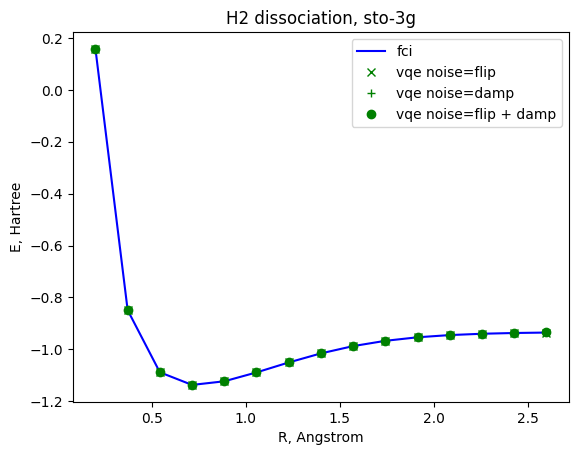

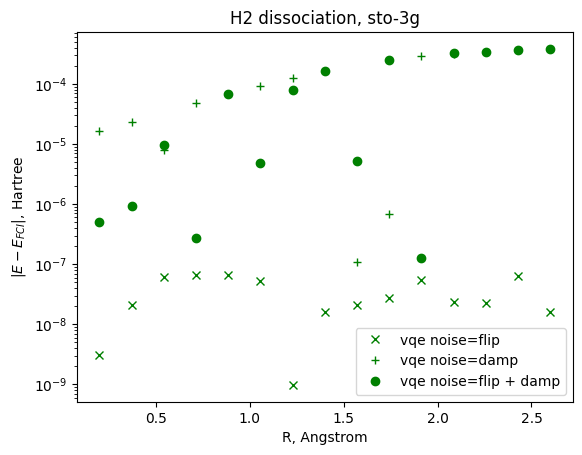

In [16]:
#Plot H2 PESs
plt.title('H2 dissociation, ' + basis)
plt.xlabel('R, Angstrom')
plt.ylabel('E, Hartree')


plt.plot(bond_lengths, energies['fci'], label='fci', **styles['fci'])
for idx, energy in enumerate(noisy_vqe_energies['vqe']):
    plt.plot(bond_lengths, energy['energy'], label='vqe noise=' + str(energy['noise'] or np.inf), color=styles['vqe']['color'], linestyle='', marker=symbols[idx])
plt.legend()
plt.show()

plt.title('H2 dissociation, ' + basis)
plt.xlabel('R, Angstrom')
plt.ylabel('$|E-E_{FCI}|$, Hartree')

for idx, energy in enumerate(noisy_vqe_energies['vqe']):
    plt.plot(bond_lengths, np.abs(energy['energy']-energies['fci']), label='vqe noise=' + str(energy['noise'] or np.inf), color=styles['vqe']['color'], linestyle='', marker=symbols[idx])
plt.legend()
plt.yscale('log')
plt.show()

Why is the effect sum of the noise models not always greater than the individual noise models? Can you add shot noise to this to see the compound effect of all noise sources?

What is the physical process for amplitude damping and bit flip? What does this mean for a single qubit system? Can you reason which area of the potential energy surface should be more affected?

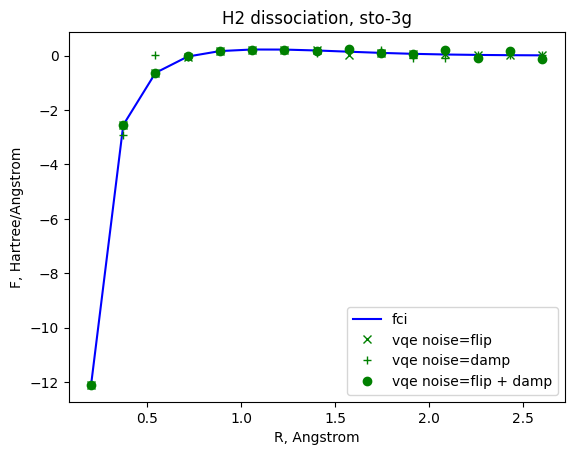

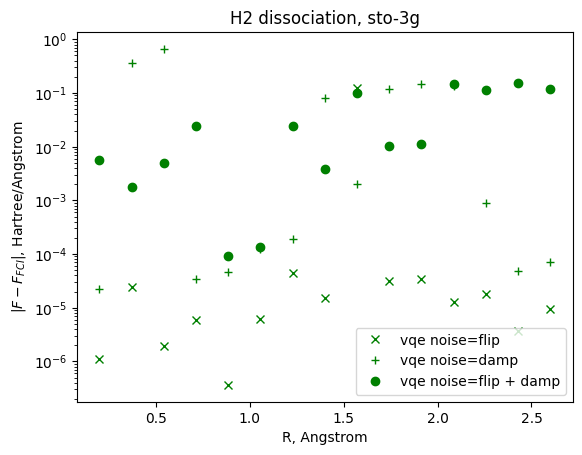

In [17]:
plt.title('H2 dissociation, ' + basis)
plt.xlabel('R, Angstrom')
plt.ylabel('F, Hartree/Angstrom')


plt.plot(bond_lengths, forces['fci'][2]['force'], label='fci', **styles['fci'])
for idx, force in enumerate(noisy_vqe_forces['vqe']):
    plt.plot(bond_lengths, force['force'], label='vqe noise=' + str(force['noise'] or np.inf), color=styles['vqe']['color'], linestyle='', marker=symbols[idx])
plt.legend()
plt.show()

plt.title('H2 dissociation, ' + basis)
plt.xlabel('R, Angstrom')
plt.ylabel('$|F-F_{FCI}|$, Hartree/Angstrom')

for idx, force in enumerate(noisy_vqe_forces['vqe']):
    plt.plot(bond_lengths, np.abs(force['force'] - forces['fci'][2]['force']), label='vqe noise=' + str(force['noise'] or np.inf), color=styles['vqe']['color'], linestyle='', marker=symbols[idx])
plt.legend()
plt.yscale('log')

plt.show()

Extra excercise: Can you simulate a realistic quantum computer? Go online and search for machine parameters that allow you to build an accurate error model and see what the result is.